# Notebook #5: Serie temporal: parámetros p=3, d=0, q=4

In [89]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
from prophet import Prophet

# Importar las clases
# -----------------------------------------------------------------------
import sys
sys.path.append('../..')
from src import soporte_temporales as st
from src import soporte_sarima as ss
from src import soporte_funciones_BBDD as sfbd
from src import soporte_variables_defunciones as svd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Calcular métricas
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuraciones
# -----------------------------------------------------------------------
pd.options.display.float_format = '{:.0f}'.format
from itertools import product

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Query para traer datos agrupados

In [90]:
df_alineados = pd.read_csv('../../Datos/datos_plus/datos_alineados_variables.csv', index_col=0)

In [91]:
df_alineados = df_alineados[['anio', 'Defunciones', 'parque_vehicular', 'poblacion']]

In [92]:
df_alineados.tail()

,anio,Defunciones,parque_vehicular,poblacion
12,2019,2100,4634876,10894043
13,2020,1737,4842367,11008300
14,2021,1874,5152448,11123476
15,2022,1794,5463996,11230734
16,2023,1949,5809136,11331265


# Defunciones

In [93]:
df_predicciones_parque = pd.read_csv('../../Datos/datos_predichos/df_parque_vehicular_predicciones.csv', index_col=0)
df_predicciones_poblacion = pd.read_csv('../../Datos/datos_predichos/df_poblacion_predicciones.csv', index_col=0)

In [96]:
# Datos para los años 2024 y 2025
nuevos_datos = {
    'anio': [2024, 2025],
    'Defunciones': [0, 0],              # Si ya tienes estas predicciones; de lo contrario, puedes dejar NaN
    'parque_vehicular': [6105369, 6385468],  # Datos predichos o estimados
    'poblacion': [11474815, 11590382],       # Datos predichos o estimados
}

# Convertir el diccionario en un DataFrame
df_nuevos = pd.DataFrame(nuevos_datos)

# Agregar el nuevo DataFrame al original
df_completo = pd.concat([df_alineados, df_nuevos], ignore_index=True)



In [98]:
# Supongamos que tu DataFrame se llama df
# Ordenar el DataFrame por año
df = df_completo.sort_values('anio')

# Separar los datos históricos y futuros
df_hist = df[df['anio'] <= 2023]
df_fut = df[df['anio'] > 2023]


In [100]:
# Variables independientes y dependiente para el entrenamiento
X_hist = df_hist[['parque_vehicular', 'poblacion']]
y_hist = df_hist['Defunciones']

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X_hist, y_hist, test_size=0.2, random_state=42, shuffle=False)
modelo = LinearRegression()
modelo.fit(X_train, y_train)

In [ ]:
# Predicciones en el conjunto de prueba
y_pred_test = modelo.predict(X_test)

# Calcular el MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Calcular el RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Imprimir los resultados
print(f"MAPE en el conjunto de prueba: {mape:.2f}%")
print(f"RMSE en el conjunto de prueba: {rmse:.2f}")

MAPE en el conjunto de prueba: 6.29%
RMSE en el conjunto de prueba: 144.23


In [112]:
print("Coeficientes:", modelo.coef_)
print("Intercepción:", modelo.intercept_)

Coeficientes: [-0.00012531  0.00014443]
Intercepción: 790.4363043993694


In [105]:
# Variables independientes para los años futuros
X_fut = df_fut[['parque_vehicular', 'poblacion']]

# Predicciones para 2024 y 2025
df_fut['Defunciones_Pred'] = modelo.predict(X_fut)

# Mostrar las predicciones
print(df_fut[['anio', 'parque_vehicular', 'poblacion', 'Defunciones_Pred']])

    anio  parque_vehicular  poblacion  Defunciones_Pred
17  2024           6105369   11474815              1683
18  2025           6385468   11590382              1664


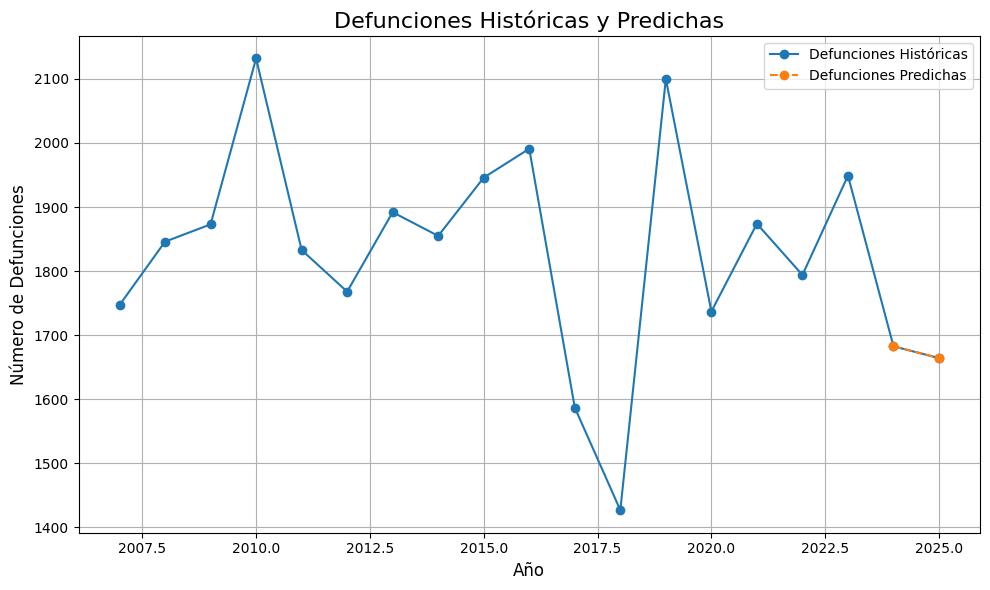

In [114]:
# Crear el gráfico
plt.figure(figsize=(10, 6))

# Datos históricos
plt.plot(df_completo['anio'], df_completo['Defunciones'], label='Defunciones Históricas', marker='o')

# Predicciones futuras
plt.plot(df_fut['anio'], df_fut['Defunciones_Pred'], label='Defunciones Predichas', marker='o', linestyle='--')

# Añadir detalles al gráfico
plt.title('Defunciones Históricas y Predichas', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Número de Defunciones', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## SARIMAX

In [ ]:
# Preparar los datos
df = df.sort_values('anio')  # Ordenar por año

# Variables dependiente e independientes
y = df['Defunciones']
X = df[['parque_vehicular', 'poblacion']]

# Dividir datos en entrenamiento (hasta 2023) y predicción futura (2024+)
train_data = df[df['anio'] <= 2023]
future_data = df[df['anio'] > 2023]

# Variables de entrenamiento
y_train = train_data['Defunciones']
X_train = train_data[['parque_vehicular', 'poblacion']]

# Modelo ARX
model = SARIMAX(y_train, exog=X_train, order=(1, 0, 0))  # (1, 0, 0) = AR(1)
model_fit = model.fit(disp=False)

# Predicciones para 2024 y 2025
X_future = future_data[['parque_vehicular', 'poblacion']]
predictions = model_fit.predict(start=len(y_train), end=len(y_train) + len(X_future) - 1, exog=X_future)

# Añadir predicciones al DataFrame futuro
future_data['Defunciones_Pred'] = predictions

# Mostrar las predicciones
print(future_data[['anio', 'Defunciones_Pred']])

    anio  Defunciones_Pred
17  2024              1764
18  2025              1774


In [116]:

# Obtener predicciones en el conjunto de entrenamiento (años históricos)
y_pred_train = model_fit.predict(start=0, end=len(y_train) - 1, exog=X_train)

# Calcular el MAPE
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))

print(f"MAPE del modelo ARX en el conjunto histórico: {mape:.2f}%")
print(f"RMSE del modelo ARX en el conjunto histórico: {rmse:.2f}")


MAPE del modelo ARX en el conjunto histórico: 6.60%
RMSE del modelo ARX en el conjunto histórico: 167.56


In [109]:
future_data

,anio,Defunciones,parque_vehicular,poblacion,Defunciones_Pred
17,2024,0,6105369,11474815,1764
18,2025,0,6385468,11590382,1774


In [110]:
df_completo

,anio,Defunciones,parque_vehicular,poblacion
0,2007,1747,2234307,9455658
1,2008,1846,2429562,9573130
2,2009,1873,2570220,9695265
3,2010,2132,2734740,9820175
4,2011,1833,2917573,9945621
5,2012,1768,3052686,10070411
6,2013,1892,3215773,10193833
7,2014,1855,3398662,10315528
8,2015,1946,3612964,10434829
9,2016,1991,3854038,10551430


In [111]:
# Asegúrate de que los años 2024 y 2025 estén identificados en el DataFrame completo
df_completo.loc[df_completo['anio'] == 2024, 'Defunciones'] = df_fut.loc[df_fut['anio'] == 2024, 'Defunciones_Pred'].values[0]
df_completo.loc[df_completo['anio'] == 2025, 'Defunciones'] = df_fut.loc[df_fut['anio'] == 2025, 'Defunciones_Pred'].values[0]

# Verifica el DataFrame actualizado
print(df_completo)


    anio  Defunciones  parque_vehicular  poblacion
0   2007         1747           2234307    9455658
1   2008         1846           2429562    9573130
2   2009         1873           2570220    9695265
3   2010         2132           2734740    9820175
4   2011         1833           2917573    9945621
5   2012         1768           3052686   10070411
6   2013         1892           3215773   10193833
7   2014         1855           3398662   10315528
8   2015         1946           3612964   10434829
9   2016         1991           3854038   10551430
10  2017         1587           4097338   10666843
11  2018         1427           4350884   10782053
12  2019         2100           4634876   10894043
13  2020         1737           4842367   11008300
14  2021         1874           5152448   11123476
15  2022         1794           5463996   11230734
16  2023         1949           5809136   11331265
17  2024         1683           6105369   11474815
18  2025         1664          

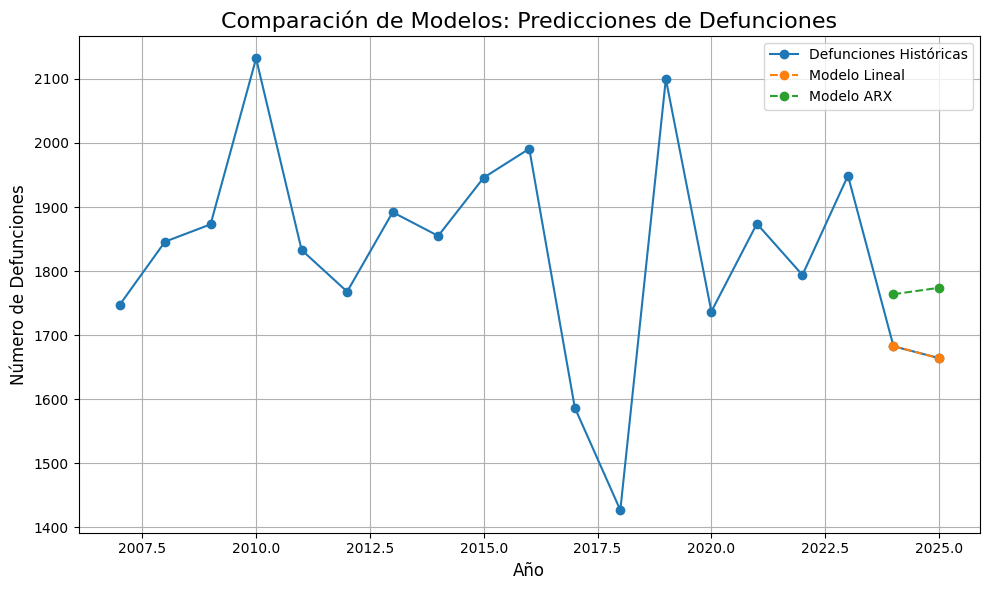

In [115]:
import matplotlib.pyplot as plt

# Crear un DataFrame con las predicciones de ambos modelos
df_predicciones = pd.DataFrame({
    'anio': [2024, 2025],
    'Modelo Lineal': [1683, 1664],
    'Modelo ARX': [1764, 1774]
})

# Añadir los datos históricos al gráfico
plt.figure(figsize=(10, 6))
plt.plot(df_completo['anio'], df_completo['Defunciones'], label='Defunciones Históricas', marker='o')
plt.plot(df_predicciones['anio'], df_predicciones['Modelo Lineal'], label='Modelo Lineal', marker='o', linestyle='--')
plt.plot(df_predicciones['anio'], df_predicciones['Modelo ARX'], label='Modelo ARX', marker='o', linestyle='--')

# Personalizar el gráfico
plt.title('Comparación de Modelos: Predicciones de Defunciones', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Número de Defunciones', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()
